In [1]:
from dotenv import load_dotenv
from phmlondon.snow_utils import SnowflakeConnection
import pandas as pd
from statsmodels.formula.api import logit
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from tqdm import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

# CONFIG

In [2]:
PHENOTYPES_OF_INTEREST = {
    "ASTHMA": "ASTHMA",
    "COPD": "COPD",
    "DIABETES_TYPE2": "DIABETES_TYPE2",
    "DIABETES_TYPE1": "DIABETES_TYPE1",
    "HYPERTENSION": "HYPERTENSION",
    "CORONARY_HEART_DISEASE": "CORONARY_HEART_DISEASE",
    "MYOCARDIAL_INFARCTION": "MYOCARDIAL_INFARCTION",
    "TIA": "TIA",
    "STROKE": "STROKE",
    "CKD_STAGE1": "CKD_STAGE1",
    "CKD_STAGE3": "CKD_STAGE3",
    "DEPRESSION": "DEPRESSION",
    "SEVERE_MENTAL_ILLNESS": "SEVERE_MENTAL_ILLNESS",
    "CANCER": "CANCER",
    "DEMENTIA": "DEMENTIA",
    "ATRIAL_FIBRILLATION": "ATRIAL_FIBRILLATION",
    "PALLIATIVE_CARE": "PALLIATIVE_CARE",
    "HEART_FAILURE": "HEART_FAILURE"
}

# FUNCTIONS

## Helper

In [3]:
def clean_column_name(col):
    """
    Clean column names for Patsy compatibility.
    """
    return col.replace('-', '_to_').replace('+', '_plus_').replace(' ', '_')

def create_dummies(df, col, ref):
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
    ref_col = f"{col}_{ref}"
    if ref_col in dummies.columns:
        dummies = dummies.drop(columns=[ref_col])
    return dummies

## Data

In [4]:
def get_modeling_data(
        snowsesh,
        phenotype_name
        ):
    """
    Retrieves modeling dataset combining active patients and phenotype data.

    Args:
        snowsesh:
            Snowflake session
        phenotype_name:
            The specific phenotype to analyse

    Returns:
        DataFrame containing features and phenotype flags for modeling
    """
    # dynamic SQL to pull phenotype
    if phenotype_name not in PHENOTYPES_OF_INTEREST:
        raise ValueError(f"Invalid phenotype name. Must be one of {list(PHENOTYPES_OF_INTEREST.keys())}")
    phenotype_db_name = PHENOTYPES_OF_INTEREST[phenotype_name]
    phenotype_col = f'COALESCE(ph."{phenotype_db_name}", 0) as "{phenotype_name}"'

    query = f"""
    WITH age_categories AS (
        SELECT
            PERSON_ID,
            CASE
                WHEN DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) < 18 THEN '0-17'
                WHEN DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) < 25 THEN '18-24'
                WHEN DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) < 35 THEN '25-34'
                WHEN DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) < 45 THEN '35-44'
                WHEN DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) < 55 THEN '45-54'
                WHEN DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) < 65 THEN '55-64'
                WHEN DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) < 75 THEN '65-74'
                ELSE '75+'
            END as AGE_BAND,
            DATEDIFF(year, DATE_OF_BIRTH, CURRENT_DATE()) as AGE_YEARS
        FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PERSON_NEL_MASTER_INDEX
    )
    SELECT
        -- Features
        p.PERSON_ID,
        p.PATIENT_LSOA_2011,
        -- Use Other/Mixed/NotStated/Unknown as REFERENCE group
        CASE
            WHEN p.ETHNIC_AIC_CATEGORY IN ('Other', 'Not Stated', 'Mixed') THEN 'Unknown'
            ELSE COALESCE(p.ETHNIC_AIC_CATEGORY, 'Unknown') -- fold into reference
        END as ETHNIC_AIC_CATEGORY,
        -- Use Female/Other as REFERENCE group
        CASE
            WHEN p.GENDER IN ('Male', 'Female') THEN p.GENDER
            ELSE 'Female'  -- fold Other into reference
        END as GENDER,
        ac.AGE_BAND,
        ac.AGE_YEARS,
        -- Normalise IMD rank to 0-1 scale
        CAST(p.LONDON_IMD_RANK as FLOAT) / (
            SELECT MAX(LONDON_IMD_RANK)
            FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PERSON_NEL_MASTER_INDEX
        ) as NORMALISED_IMD_RANK,
        -- p.IMD_QUINTILE, -- exclude as we are using normalised rank
        -- Phenotype flags (coalesce to 0 for patients without records)
        {phenotype_col}
    FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PERSON_NEL_MASTER_INDEX p
    INNER JOIN age_categories ac
        ON p.PERSON_ID = ac.PERSON_ID
    LEFT JOIN INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PERSON_5YEAR_PHENOTYPE ph
        ON p.PERSON_ID = ph.PERSON_ID
    WHERE p.PATIENT_STATUS = 'ACTIVE'
    AND p.LONDON_IMD_RANK IS NOT NULL -- Exclude missing IMD for demo run
    AND p.INCLUDE_IN_LIST_SIZE_FLAG = 1
    """

    try:
        df = snowsesh.execute_query_to_df(query)
        print(f"Retreived columns: {df.columns}")
        return df
    except Exception as e:
        print(f"Error retrieving modeling data: {e}")
        raise e

def prepare_modeling_data(
        df,
        phenotype_name
        ):
    """
    Prepares data for modeling by encoding categorical variables and handling missing values.

    Args:
        df:
            Input DataFrame
        phenotype_name:
            Name of the phenotype (now outcome column header)

    Returns:
        Tuple of modeling DataFrame, metadata dict)
    """
    df_prep = df.copy()

    # Set reference categories for categorical variables
    cat_refs = {
        'ETHNIC_AIC_CATEGORY': 'Unknown',
        'GENDER': 'Female',
        'AGE_BAND': '45-54',  # Middle age as reference
    }

    # create dummy variables
    for col, ref in cat_refs.items():
        df_prep = pd.concat([df_prep, create_dummies(df_prep, col, ref)], axis=1)

    # clean columns
    column_mapping = {col: clean_column_name(col) for col in df_prep.columns}
    df_prep = df_prep.rename(columns=column_mapping)

    # create features
    feature_cols = [col for col in df_prep.columns if col.startswith(tuple(cat_refs.keys()))]
    for col in cat_refs:
        feature_cols.remove(col) # Remove original columns after dummy creation
    feature_cols.append('NORMALISED_IMD_RANK') # add other columns of interest here

    # Create final modeling dataset
    X = df_prep[feature_cols]
    y = df_prep[phenotype_name]

    # Combine into single dataframe
    model_df = pd.concat([X, y], axis=1)

    # Store column information
    metadata = {
        'feature_cols': feature_cols,
        'outcome_col': phenotype_name,
        'categorical_refs': cat_refs
    }

    # print basic checks (debug)
    # print("Dataset Shape:")
    # print(model_df.shape)

    # print("Metadata Dictionary:")
    # print(metadata)

    # print("Outcome Distribution:")
    # outcome = metadata['outcome_col']
    # print(model_df[outcome].value_counts(normalize=True))

    # print("Missing Values:")
    # print(model_df.isnull().sum()[model_df.isnull().sum() > 0])

    # model_df.to_csv('model_df.csv')

    return model_df, metadata

## Fit Models

In [5]:
def fit_logistic_models(
        model_df,
        metadata,
        phenotype_name
        ):
    """
    Fits logistic regression models with interaction terms and extracts odds ratios.
    Interactions: ethnicity x age; ethnicity x deprivation

    Args:
        model_df:
            Prepared modeling DataFrame
        metadata:
            Dictionary containing feature information
        phenotype_name:
            Name of the phenotype/outcome column

    Returns:
        Tuple containing:
        - Dictionary of fitted models
        - DataFrame for effect modification plots
        - DataFrame for stratified probability plots
    """

    # list features for interactions
    feature_cols = metadata['feature_cols']
    ethnic_cols = [col for col in feature_cols if col.startswith('ETHNIC_AIC_CATEGORY_')]
    age_cols = [col for col in feature_cols if col.startswith('AGE_BAND_')]
    interaction_col = "NORMALISED_IMD_RANK"

    # dyanmic formula generation including interaction terms
    # e = ethnic subgropu
    # a = age band
    formula = f"{phenotype_name} ~ {' + '.join(feature_cols)} + {' + '.join([f'{e}:{a}' for e in ethnic_cols for a in age_cols])} + {' + '.join([f'{e}:{interaction_col}' for e in ethnic_cols])}"

    # fit!
    try:
        model = logit(formula, data=model_df).fit(method='bfgs') ## more robust to low variance/singular matrix errors
    except Exception as e:
        print(f"Formula that caused error: {formula}")
        raise e

    odds_ratios = pd.DataFrame({
        'odds_ratio': np.exp(model.params),
        'lower_ci': np.exp(model.conf_int()[0]),
        'upper_ci': np.exp(model.conf_int()[1])
    })

    pseudo_r_squared = model.prsquared

    return {
        'model': model,
        'odds_ratios': odds_ratios,
        'pseudo_r_squared': pseudo_r_squared,
        'formula': formula # store the formula for debugging
    }

def print_model_summary(model_dict):
    """
    Creates a detailed summary of the logistic regression model results.

    Args:
        model_dict:
            Dictionary containing the fitted model and other information.

    Returns:
        DataFrame containing formatted model results
    """
    model = model_dict['model']

    summary_df = pd.DataFrame({
        'Coefficient': model.params,
        'Std Error': model.bse,
        'z-value': model.tvalues,
        'P>|z|': model.pvalues,
        'OR': np.exp(model.params),
        '[0.025': np.exp(model.conf_int()[0]),
        '0.975]': np.exp(model.conf_int()[1])
    })

    summary_df = summary_df.round(4)

    summary_df['Significance'] = ''
    summary_df.loc[summary_df['P>|z|'] < 0.05, 'Significance'] = '*'
    summary_df.loc[summary_df['P>|z|'] < 0.01, 'Significance'] = '**'
    summary_df.loc[summary_df['P>|z|'] < 0.001, 'Significance'] = '***'

    print("Model Fit Statistics:")
    print(f"Number of observations: {model.nobs}")
    print(f"Pseudo R-squared: {model.prsquared:.4f}")
    print(f"Log-Likelihood: {model.llf:.4f}")
    print(f"AIC: {model.aic:.4f}")
    print(f"BIC: {model.bic:.4f}")
    print("Likelihood Ratio Test:")
    print(f"Chi2: {model.llr:.4f}")
    print(f"p-value: {model.llr_pvalue:.4f}")

    return summary_df


## Risk Calculations

In [6]:
def calculate_individual_risks(
        df,
        model_dict,
        metadata
        ):
    """
    Calculates individual risk scores using fitted model.

    Args:
        df:
            Original dataframe containing patient data
        model_dict:
            Dictionary containing fitted model and results
        metadata:
            Dictionary containing feature information

    Returns:
        DataFrame with original data plus risk scores and predictions
    """
    model = model_dict['model']

    # Create prediction dataframe wit same structure as training data
    pred_df = prepare_modeling_data(df, metadata['outcome_col'])[0]

    # return linear predictors /log-odds
    linear_predictor = model.predict(pred_df, linear=True)

    # return probabilities
    probabilities = model.predict(pred_df)

    # Add predictions to original dataframe
    results_df = df.copy()
    results_df['predicted_risk'] = probabilities
    results_df['linear_predictor'] = linear_predictor

    # Add binary prediction using 0.5 threshold (we can adjust this - I haven't calibrated)
    results_df['predicted_case'] = (probabilities >= 0.5).astype(int)

    return results_df

def analyse_geographic_risk(
        risk_df,
        phenotype_name,
        grouping_level='LSOA'):
    """
    Aggregates risks and actual cases by geographic area.

    Args:
        risk_df:
            DataFrame with individual risks and actual phenotype status
        phenotype_name:
            Name of the phenotype being analyzed
        grouping_level:
            Geographic level for aggregation (only LSOA for now)

    Returns:
        DataFrame with geographic risk analysis
    """
    if grouping_level == 'LSOA':
        geo_col = 'PATIENT_LSOA_2011'
    else:
        raise ValueError(f"Unsupported geographic level: {grouping_level}")

    # Aggregate by geographic area
    geo_analysis = risk_df.groupby(geo_col).agg({
        'predicted_risk': ['count', 'mean', 'sum'],  # sum gives expected number of cases
        phenotype_name: ['sum'],  # actual cases
        'PERSON_ID': 'count'  # = pop size
    }).reset_index()

    # flatten multi-level df into multipart column names
    geo_analysis.columns = [
        f"{'' if col[0] == geo_col else col[0]}_{col[1]}"
        if col[1] != '' else col[0]
        for col in geo_analysis.columns
    ]

    # summarise metrics
    geo_analysis['expected_cases'] = geo_analysis['predicted_risk_sum']
    geo_analysis['actual_cases'] = geo_analysis[f'{phenotype_name}_sum']
    geo_analysis['population'] = geo_analysis['PERSON_ID_count']
    geo_analysis['case_difference'] = geo_analysis['actual_cases'] - geo_analysis['expected_cases']
    geo_analysis['standardized_difference'] = geo_analysis['case_difference'] / np.sqrt(geo_analysis['population'])

    # Calculate 95% confidence intervals for the difference
    geo_analysis['difference_ci_lower'] = geo_analysis['case_difference'] - (1.96 * np.sqrt(geo_analysis['population']))
    geo_analysis['difference_ci_upper'] = geo_analysis['case_difference'] + (1.96 * np.sqrt(geo_analysis['population']))

    # Flag areas with significant under-diagnosis
    geo_analysis['significant_under_diagnosis'] = geo_analysis['difference_ci_upper'] < 0

    return geo_analysis

def summarise_risk_analysis(
        geo_analysis,
        phenotype_name
        ):
    """
    Provides summary statistics of the geographic risk analysis.

    Args:
        geo_analysis:
            Output from analyse_geographic_risk
        phenotype_name:
            Name of the phenotype being analyzed

    Returns:
        Dictionary containing summary statistics
    """
    summary = {
        'phenotype': phenotype_name,
        'total_population': int(geo_analysis['population'].sum()),
        'total_actual_cases': int(geo_analysis['actual_cases'].sum()),
        'total_expected_cases': int(round(geo_analysis['expected_cases'].sum())),
        'total_case_difference': int(round(geo_analysis['case_difference'].sum())),
        'areas_analyzed': len(geo_analysis),
        'areas_under_diagnosed': int(geo_analysis['significant_under_diagnosis'].sum()),
        'percent_areas_under_diagnosed': round(100 * geo_analysis['significant_under_diagnosis'].mean(), 1)
    }

    return summary

## Effect Modification

In [7]:
def create_effect_modification_df(
        model_dict,
        metadata
        ):
    """
    Creates effect modification dataframe from model coefficients showing odds ratios
    across different strata.

    Args:
        model_dict:
            Dictionary containing fitted model and results
        metadata:
            Dictionary containing feature information

    Returns:
        DataFrame containing effect modification results for age and IMD interactions
    """
    model = model_dict['model']
    records = []

    # Extract coefficients and confidence intervals
    coef = model.params
    conf_int = model.conf_int()

    # Get ethnic groups
    ethnic_groups = [col.replace('ETHNIC_AIC_CATEGORY_', '').replace('[T.True]', '')
                    for col in coef.index
                    if col.startswith('ETHNIC_AIC_CATEGORY_') and ':' not in col]

    # Get age bands
    age_bands = [col.replace('AGE_BAND_', '').replace('[T.True]', '')
                 for col in coef.index
                 if col.startswith('AGE_BAND_') and ':' not in col]

    # Process age band interactions
    for ethnic in ethnic_groups:
        ethnic_col = f'ETHNIC_AIC_CATEGORY_{ethnic}[T.True]'

        # Get main effect/ci for ethnicity
        ethnic_effect = coef[ethnic_col]
        ethnic_ci = conf_int.loc[ethnic_col]

        # calculate adjusted effect at each age band
        for age in age_bands:
            age_col = f'AGE_BAND_{age}[T.True]'
            interaction_term = f"{ethnic_col}:{age_col}"

            # adjusted effect of main + interaction)
            main_age_effect = coef[age_col] if age_col in coef else 0
            interaction_effect = coef[interaction_term] if interaction_term in coef else 0
            total_effect = ethnic_effect + main_age_effect + interaction_effect

            # confidence intervals
            main_age_ci = conf_int.loc[age_col] if age_col in conf_int.index else [0, 0]
            interaction_ci = conf_int.loc[interaction_term] if interaction_term in conf_int.index else [0, 0]
            lower_ci = ethnic_ci[0] + main_age_ci[0] + interaction_ci[0]
            upper_ci = ethnic_ci[1] + main_age_ci[1] + interaction_ci[1]

            records.append({
                'effect_modifier': 'age_band',
                'modifier_value': age,
                'ethnic_group': ethnic,
                'odds_ratio': np.exp(total_effect),
                'lower_ci': np.exp(lower_ci),
                'upper_ci': np.exp(upper_ci)
            })

    # Process IMD interactions
    imd_values = np.linspace(0, 1, 20)  # Take 20 points across IMD range

    for ethnic in ethnic_groups:
        ethnic_col = f'ETHNIC_AIC_CATEGORY_{ethnic}[T.True]'

        # Get main effect/ci for ethnicity
        ethnic_effect = coef[ethnic_col]
        ethnic_ci = conf_int.loc[ethnic_col]

        # Get IMD effect/ci
        imd_effect = coef['NORMALISED_IMD_RANK']
        imd_ci = conf_int.loc['NORMALISED_IMD_RANK']

        # Get interaction effect
        interaction_term = f"{ethnic_col}:NORMALISED_IMD_RANK"
        interaction_effect = coef[interaction_term] if interaction_term in coef else 0
        interaction_ci = conf_int.loc[interaction_term] if interaction_term in conf_int.index else [0, 0]

        for imd in imd_values:
            # imd and interaction effects as log-odds change per unit of imd
            total_effect = ethnic_effect + (imd_effect * imd) + (interaction_effect * imd)

            # confidence intervals
            lower_ci = (ethnic_ci[0] + (imd_ci[0] * imd) + (interaction_ci[0] * imd))
            upper_ci = (ethnic_ci[1] + (imd_ci[1] * imd) + (interaction_ci[1] * imd))

            records.append({
                'effect_modifier': 'imd_rank',
                'modifier_value': imd,
                'ethnic_group': ethnic,
                'odds_ratio': np.exp(total_effect),
                'lower_ci': np.exp(lower_ci),
                'upper_ci': np.exp(upper_ci)
            })

    return pd.DataFrame(records)

## Visualisation

In [8]:
## seaborn / matplotlib

def plot_effect_modifications(
        effect_df,
        phenotype_name
        ):
    """
    Creates two plots showing effect modification by age and IMD.
    """
    sns.set_theme()
    sns.set_palette("deep")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # age band plot
    age_df = effect_df[effect_df['effect_modifier'] == 'age_band']

    # # convert age bands to categorical for proper ordering
    # age_order = ['0_minus_17', '18_minus_24', '25_minus_34', '35_minus_44',
    #              '45_minus_54', '55_minus_64', '65_minus_74', '75_plus_']

    for ethnic in age_df['ethnic_group'].unique():
        ethnic_data = age_df[age_df['ethnic_group'] == ethnic]
        ax1.plot(ethnic_data['modifier_value'], ethnic_data['odds_ratio'],
                marker='o', label=ethnic)
        ax1.fill_between(ethnic_data['modifier_value'],
                        ethnic_data['lower_ci'],
                        ethnic_data['upper_ci'],
                        alpha=0.2)

    ax1.set_title(f'Age Effect Modification for {phenotype_name}')
    ax1.set_xlabel('Age Band')
    ax1.set_ylabel('OR')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # IMD rank plot
    imd_df = effect_df[effect_df['effect_modifier'] == 'imd_rank']

    for ethnic in imd_df['ethnic_group'].unique():
        ethnic_data = imd_df[imd_df['ethnic_group'] == ethnic].copy()
        ethnic_data['modifier_value'] = pd.to_numeric(ethnic_data['modifier_value'])
        ethnic_data = ethnic_data.sort_values('modifier_value')

        ax2.plot(ethnic_data['modifier_value'], ethnic_data['odds_ratio'],
                label=ethnic)
        ax2.fill_between(ethnic_data['modifier_value'],
                        ethnic_data['lower_ci'],
                        ethnic_data['upper_ci'],
                        alpha=0.2)

    ax2.set_title(f'IMD Rank Effect Modification for {phenotype_name}')
    ax2.set_xlabel('Normalized IMD Rank (0 = Most Deprived, 1 = Least Deprived)')
    ax2.set_ylabel('OR')
    ax2.grid(True, alpha=0.3)

    # layout
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left', title="Ethnic Group")

    plt.tight_layout()

    return fig

## altair - use this code in stremlit

def plot_effect_modifications_altair(
        effect_df,
        phenotype_name
        ):
    """
    Basic Altair plots showing effect modification by age and IMD.
    """
    # Age band plot
    age_df = effect_df[effect_df['effect_modifier'] == 'age_band']

    age_chart = alt.Chart(age_df).mark_line().encode(
        x='modifier_value:N',
        y='odds_ratio:Q',
        color='ethnic_group:N'
    ).properties(
        width=400,
        height=300,
        title=f'Age Effect for {phenotype_name}'
    )

    # IMD plot
    imd_df = effect_df[effect_df['effect_modifier'] == 'imd_rank'].copy()
    imd_df['modifier_value'] = pd.to_numeric(imd_df['modifier_value'])

    imd_chart = alt.Chart(imd_df).mark_line().encode(
        x='modifier_value:Q',
        y='odds_ratio:Q',
        color='ethnic_group:N'
    ).properties(
        width=400,
        height=300,
        title=f'IMD Effect for {phenotype_name}'
    )

    # combine plots
    return alt.hconcat(age_chart, imd_chart)


# TEST PIPELINE

In [9]:
load_dotenv()

snowsesh = SnowflakeConnection()
snowsesh.use_database("INTELLIGENCE_DEV")
snowsesh.use_schema("AI_CENTRE_FEATURE_STORE")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZJRb9owFIX%2FSuQ9J7EDocQCKlpIh9RtWUM3tDfHcaiFY2e2Q8p%2B%2FZwAUvfQPuzNss%2B93%2FE9d3b7WgvvyLThSs4BCiDwmKSq5HI%2FB8%2Fb1J8Cz1giSyKUZHNwYgbcLmaG1KLBy9a%2ByCf2u2XGeq6RNLh%2FmINWS6yI4QZLUjODLcX58ssjjgKIiTFMW4cDl5LScMd6sbbBYdh1XdCNAqX3YQQhDGESOlUv%2BQTeIJqPGY1WVlElriWv7k%2FvIFAIxz3CKRwhuxTecXkewUeU4iwy%2BPN2m%2FnZt3wLvOX1d%2FdKmrZmOmf6yCl7fno8GzDOQb6OJ2g6CdqDb5SbYUD%2BtJoFRqquEuTAqKqb1rrWgTuFFStDofbcDWyzmoPmwEuLql2Rpvy4yfL8%2Bx0dJ%2BOH3U9LpyYXa0iPp7TYPZTrhqaUAu%2FHNd6oj3djTMs2sg%2FVuisYxT6MfJhs0QjHMR6hILmJfwFv5ULlktih8up88BHUnGplVGWVFFyyweUU3kzGo4T6cYEqf8xQ7CeIEZ%2FAoqpgMSoqNAn76CJwXh88GNGL%2FxrKLHzb4rKOX11Cm1WmBKcnL1W6Jvb9AFGAhhte%2BtUgxawmXCzLUjNjXJBCqO5eM2

In [10]:
# Get data for a specific phenotype
phenotype_name = "HYPERTENSION"
df = get_modeling_data(snowsesh, phenotype_name)
df.head()

Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'HYPERTENSION'],
      dtype='object')


,PERSON_ID,PATIENT_LSOA_2011,ETHNIC_AIC_CATEGORY,GENDER,AGE_BAND,AGE_YEARS,NORMALISED_IMD_RANK,HYPERTENSION
0,2490135,E01033703,White,Male,45-54,52,0.144571,0
1,283974,E01002302,White,Female,25-34,28,0.564633,0
2,1912308,E01003617,Black,Female,25-34,25,0.239710,0
3,924106,E01000056,White,Male,45-54,47,0.112099,0
4,2273983,E01004369,White,Female,25-34,29,0.642192,0


In [11]:
# Prepare data for modelling
model_df, metadata = prepare_modeling_data(df, phenotype_name)
model_df.head()

,ETHNIC_AIC_CATEGORY_Black,ETHNIC_AIC_CATEGORY_East_Or_Other_Asian,ETHNIC_AIC_CATEGORY_South_Asian,ETHNIC_AIC_CATEGORY_White,GENDER_Male,AGE_BAND_0_to_17,AGE_BAND_18_to_24,AGE_BAND_25_to_34,AGE_BAND_35_to_44,AGE_BAND_55_to_64,AGE_BAND_65_to_74,AGE_BAND_75_plus_,NORMALISED_IMD_RANK,HYPERTENSION
0,False,False,False,True,True,False,False,False,False,False,False,False,0.144571,0
1,False,False,False,True,False,False,False,True,False,False,False,False,0.564633,0
2,True,False,False,False,False,False,False,True,False,False,False,False,0.239710,0
3,False,False,False,True,True,False,False,False,False,False,False,False,0.112099,0
4,False,False,False,True,False,False,False,True,False,False,False,False,0.642192,0


In [12]:
# Logit model
model_results = fit_logistic_models(model_df, metadata, phenotype_name)
model_summary = print_model_summary(model_results)

print("Model Summary:")
print(model_summary)

print("Odds Ratios:")
print(model_results['odds_ratios'])

print("Pseudo R-squared:")
print(model_results['pseudo_r_squared'])

print("Formula:")
print(model_results['formula'])

/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.180671
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Model Fit Statistics:
Number of observations: 2432044
Pseudo R-squared: 0.2662
Log-Likelihood: -439400.1079
AIC: 878892.2157
BIC: 879476.6109
Likelihood Ratio Test:
Chi2: 318752.2668
p-value: 0.0000
Model Summary:
                                                    Coefficient  Std Error  \
Intercept                                               -2.3260     0.0251   
ETHNIC_AIC_CATEGORY_Black[T.True]                        0.3342     0.0303   
ETHNIC_AIC_CATEGORY_East_Or_Other_Asian[T.True]         -0.1959     0.0439   
ETHNIC_AIC_CATEGORY_South_Asian[T.True]                  0.2103     0.0289   
ETHNIC_AIC_CATEGORY_White[T.True]                       -0.4370     0.0286   
GENDER_Male[T.True]                                     -0.0129     0.0056   
AGE_BAND_0_to_17[T.True]                                -2.7398     0.0508   
AGE_BAND_18_to_24[T.True]   

In [13]:
risk_df = calculate_individual_risks(df, model_results, metadata)
geo_analysis = analyse_geographic_risk(risk_df, phenotype_name)

summary_stats = summarise_risk_analysis(geo_analysis, phenotype_name)

print(f"Summary for {phenotype_name}:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


Summary for HYPERTENSION:
phenotype: HYPERTENSION
total_population: 2432044
total_actual_cases: 163311
total_expected_cases: 165512
total_case_difference: -2201
areas_analyzed: 1037
areas_under_diagnosed: 2
percent_areas_under_diagnosed: 0.2


In [14]:
effect_df = create_effect_modification_df(model_results, metadata)
effect_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   effect_modifier  108 non-null    object 
 1   modifier_value   108 non-null    object 
 2   ethnic_group     108 non-null    object 
 3   odds_ratio       108 non-null    float64
 4   lower_ci         108 non-null    float64
 5   upper_ci         108 non-null    float64
dtypes: float64(3), object(3)
memory usage: 5.2+ KB


In [15]:
effect_df.head()

,effect_modifier,modifier_value,ethnic_group,odds_ratio,lower_ci,upper_ci
0,age_band,0_to_17,Black,0.058702,0.042936,0.080258
1,age_band,18_to_24,Black,0.172118,0.127788,0.231827
2,age_band,25_to_34,Black,0.105149,0.078737,0.140421
3,age_band,35_to_44,Black,0.574933,0.467741,0.706689
4,age_band,55_to_64,Black,4.541242,3.784760,5.448926


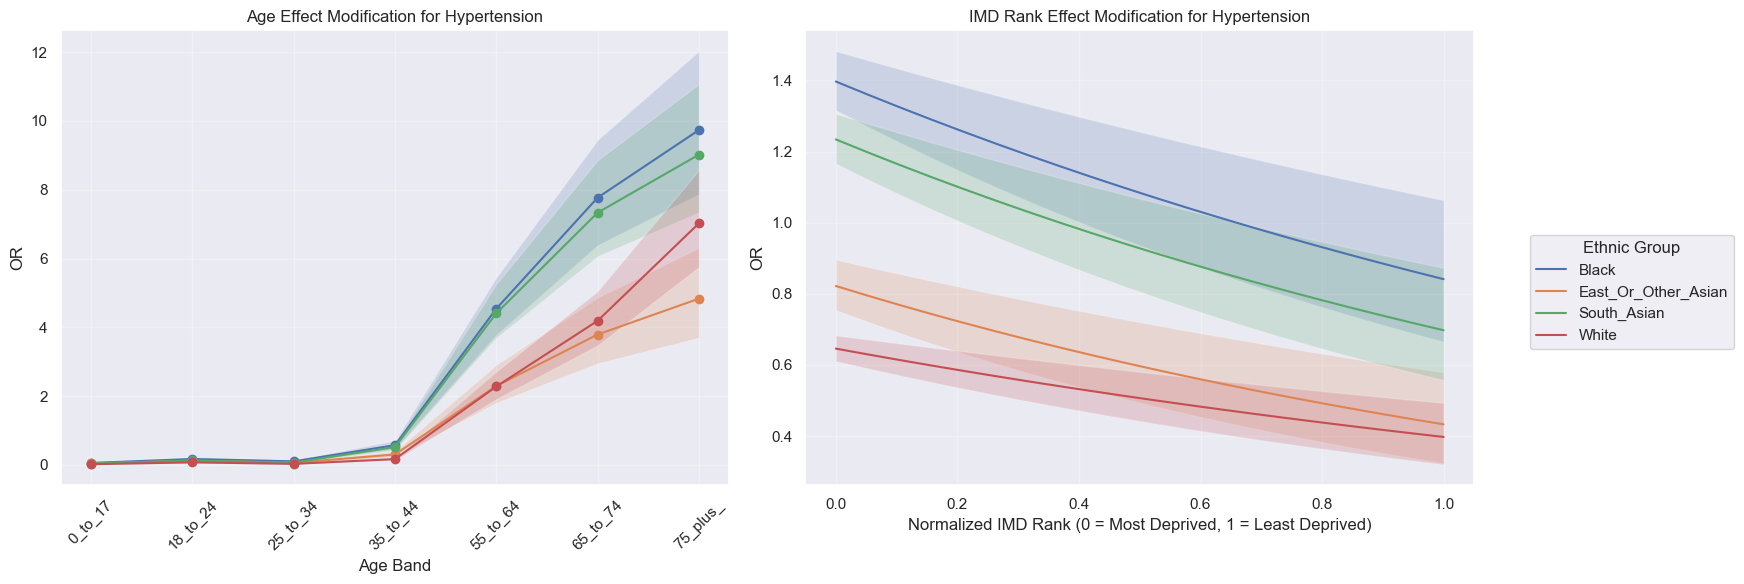

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


fig = plot_effect_modifications(effect_df, "Hypertension")
plt.show()

In [17]:
alt.renderers.enable('default')
chart = plot_effect_modifications_altair(effect_df, "Hypertension")
chart

alt.HConcatChart(...)

# MAIN (LOOP)

Processing phenotypes:   0%|          | 0/18 [00:00<?, ?it/s]

Now modelling ASTHMA
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'ASTHMA'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.181525
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ASTHMA effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:   6%|▌         | 1/18 [00:27<07:45, 27.40s/it]

Now modelling COPD
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'COPD'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.038267
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
COPD effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  11%|█         | 2/18 [00:54<07:18, 27.38s/it]

Now modelling DIABETES
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'DIABETES'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.167528
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
DIABETES effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  17%|█▋        | 3/18 [01:22<06:54, 27.65s/it]

Now modelling DIABETES_TYPE2
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'DIABETES_TYPE2'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.158516
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
DIABETES_TYPE2 effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  22%|██▏       | 4/18 [01:50<06:29, 27.79s/it]

Now modelling DIABETES_TYPE1
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'DIABETES_TYPE1'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.018108
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
DIABETES_TYPE1 effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  28%|██▊       | 5/18 [02:18<06:02, 27.87s/it]

Now modelling HYPERTENSION
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'HYPERTENSION'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.180671
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


HYPERTENSION effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  33%|███▎      | 6/18 [02:45<05:29, 27.50s/it]

Now modelling CORONARY_HEART_DISEASE
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK',
       'CORONARY_HEART_DISEASE'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.030236
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
CORONARY_HEART_DISEASE effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  39%|███▉      | 7/18 [03:12<04:59, 27.20s/it]

Now modelling MYOCARDIAL_INFARCTION
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK',
       'MYOCARDIAL_INFARCTION'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.021954
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MYOCARDIAL_INFARCTION effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  44%|████▍     | 8/18 [03:40<04:37, 27.73s/it]

Now modelling TIA
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'TIA'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.011762
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TIA effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  50%|█████     | 9/18 [04:10<04:15, 28.38s/it]

Now modelling STROKE
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'STROKE'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.009799
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
STROKE effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  56%|█████▌    | 10/18 [04:37<03:43, 27.97s/it]

Now modelling CKD_STAGE1
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'CKD_STAGE1'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.022779
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
CKD_STAGE1 effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  61%|██████    | 11/18 [05:05<03:14, 27.80s/it]

Now modelling CKD_STAGE3
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'CKD_STAGE3'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.070620
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
CKD_STAGE3 effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  67%|██████▋   | 12/18 [05:32<02:45, 27.56s/it]

Now modelling DEPRESSION
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'DEPRESSION'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.187889
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
DEPRESSION effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  72%|███████▏  | 13/18 [05:59<02:17, 27.56s/it]

Now modelling SEVERE_MENTAL_ILLNESS
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK',
       'SEVERE_MENTAL_ILLNESS'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.044893
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
SEVERE_MENTAL_ILLNESS effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  78%|███████▊  | 14/18 [06:26<01:49, 27.44s/it]

Now modelling CANCER
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'CANCER'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.055016
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
CANCER effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  83%|████████▎ | 15/18 [06:54<01:22, 27.41s/it]

Now modelling DEMENTIA
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'DEMENTIA'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.015340
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
DEMENTIA effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  89%|████████▉ | 16/18 [07:21<00:54, 27.35s/it]

Now modelling ATRIAL_FIBRILLATION
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'ATRIAL_FIBRILLATION'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.030313
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ATRIAL_FIBRILLATION effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes:  94%|█████████▍| 17/18 [07:48<00:27, 27.37s/it]

Now modelling PALLIATIVE_CARE
Retreived columns: Index(['PERSON_ID', 'PATIENT_LSOA_2011', 'ETHNIC_AIC_CATEGORY', 'GENDER',
       'AGE_BAND', 'AGE_YEARS', 'NORMALISED_IMD_RANK', 'PALLIATIVE_CARE'],
      dtype='object')


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.013332
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
PALLIATIVE_CARE effects appended


/Users/jzhang/.pyenv/versions/snowpark/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
Processing phenotypes: 100%|██████████| 18/18 [08:15<00:00, 27.54s/it]

Saved combined effects for 18 phenotypes
Saved combined risk analysis for 18 phenotypes
SHOWING: ASTHMA


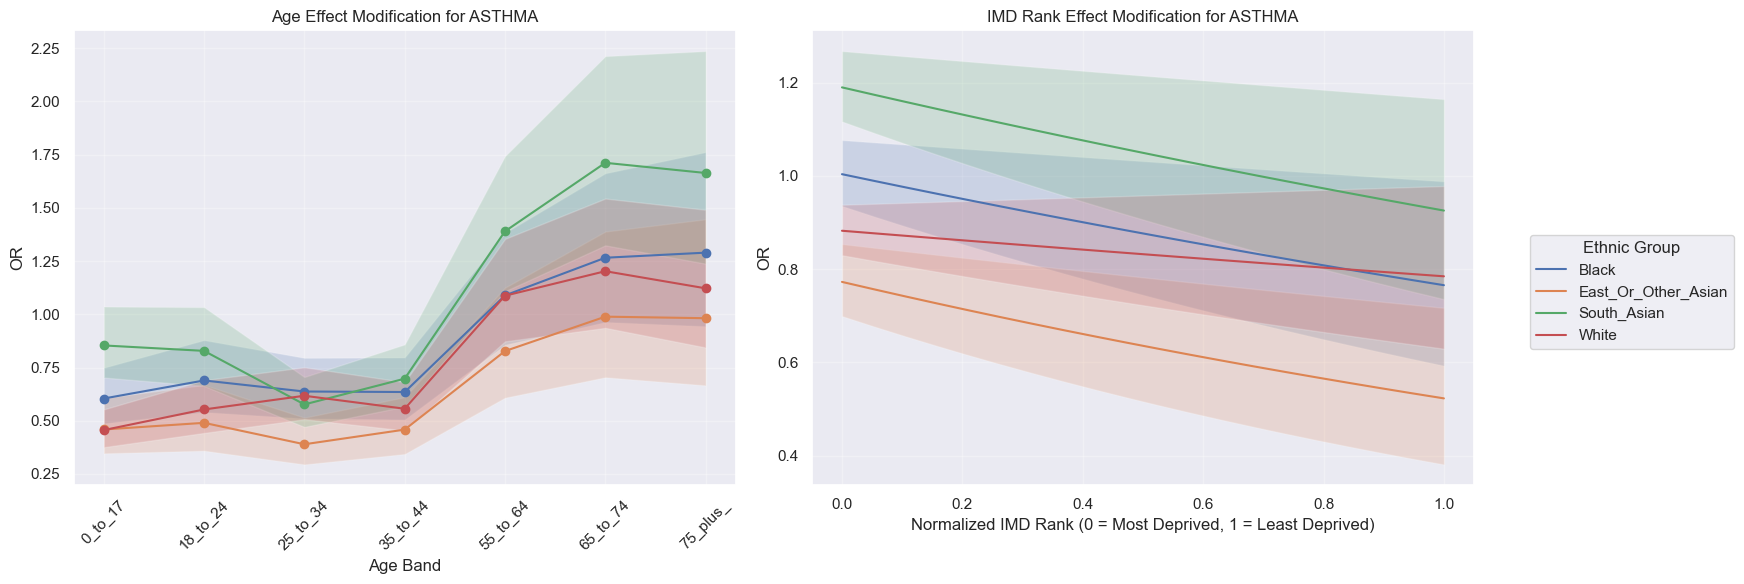

SHOWING: COPD


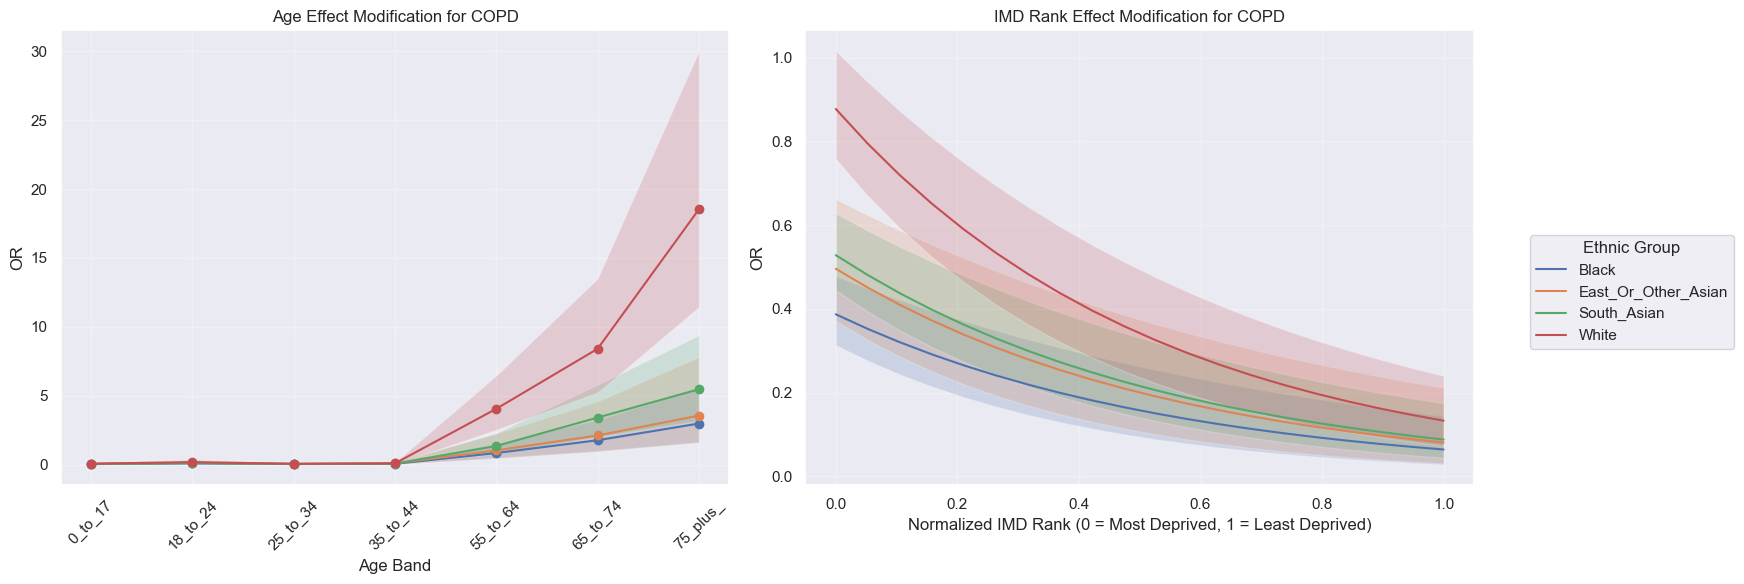

SHOWING: DIABETES


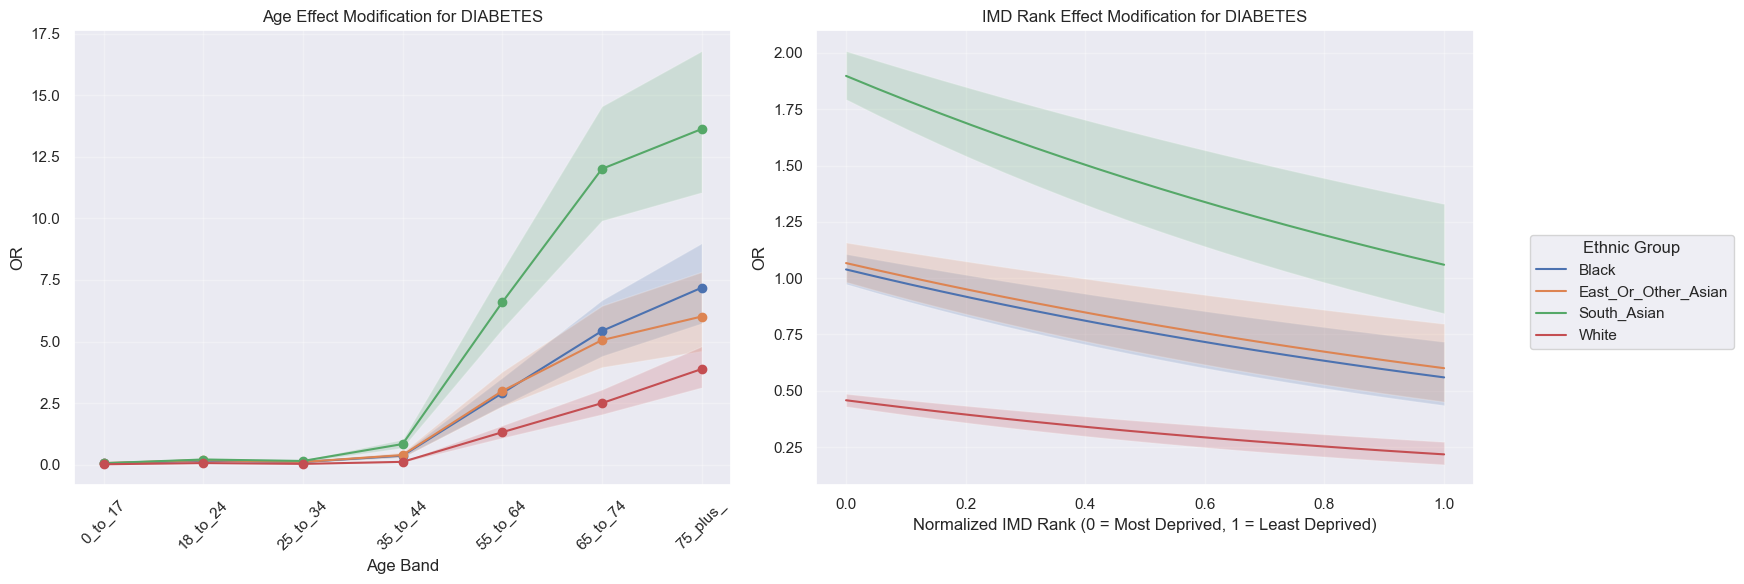

SHOWING: DIABETES_TYPE2


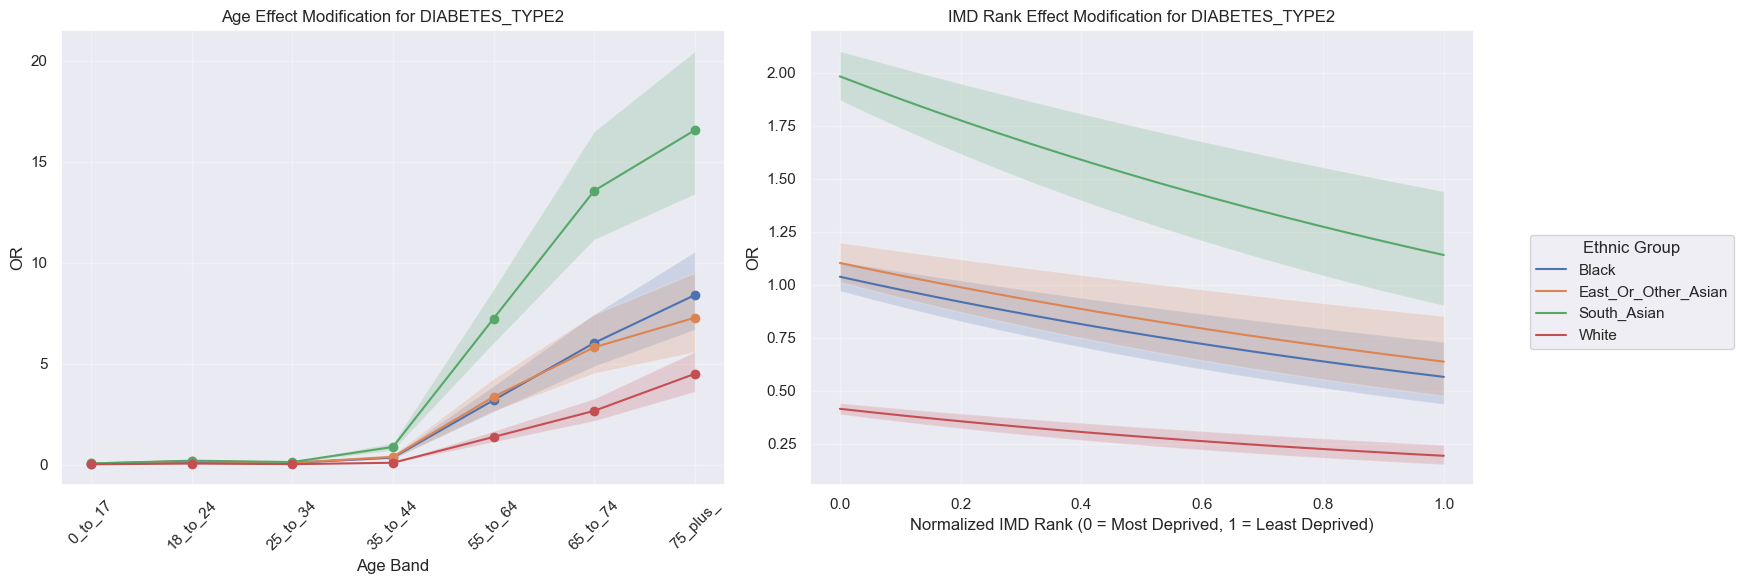

SHOWING: DIABETES_TYPE1


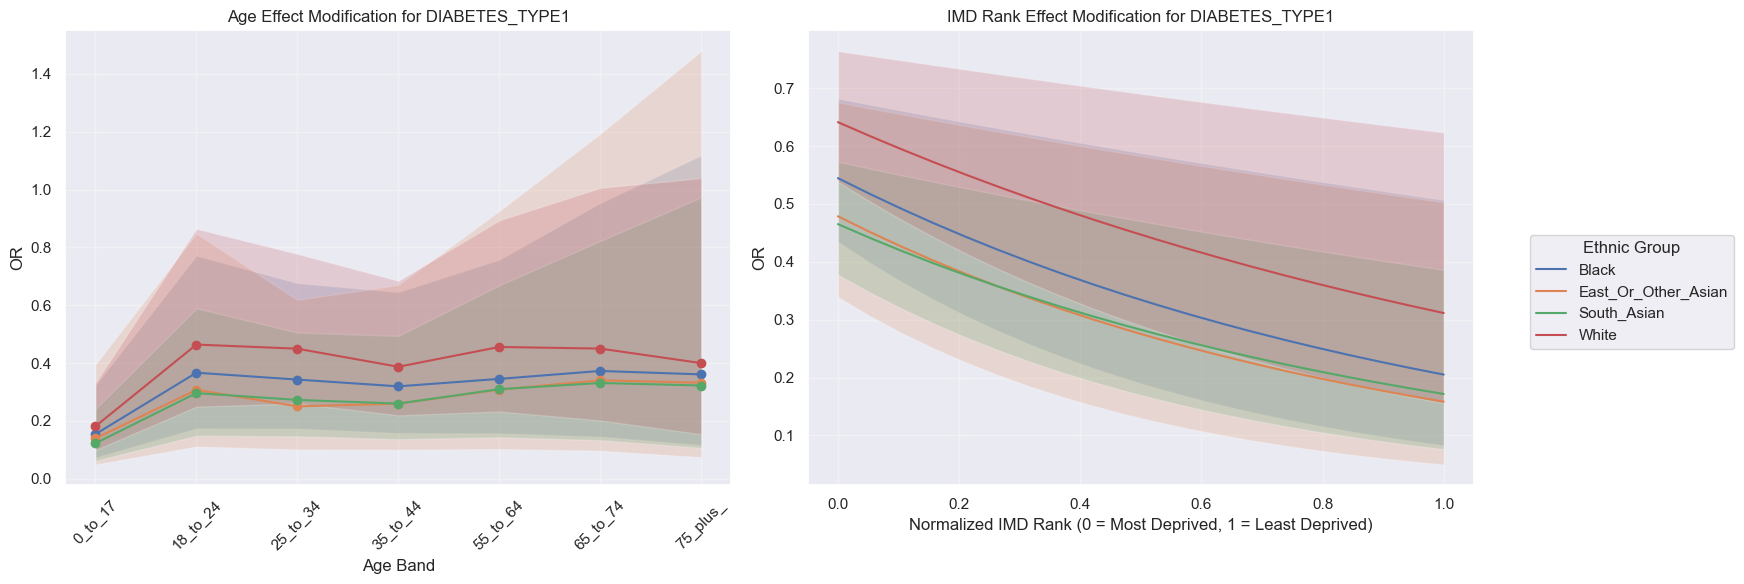

SHOWING: HYPERTENSION


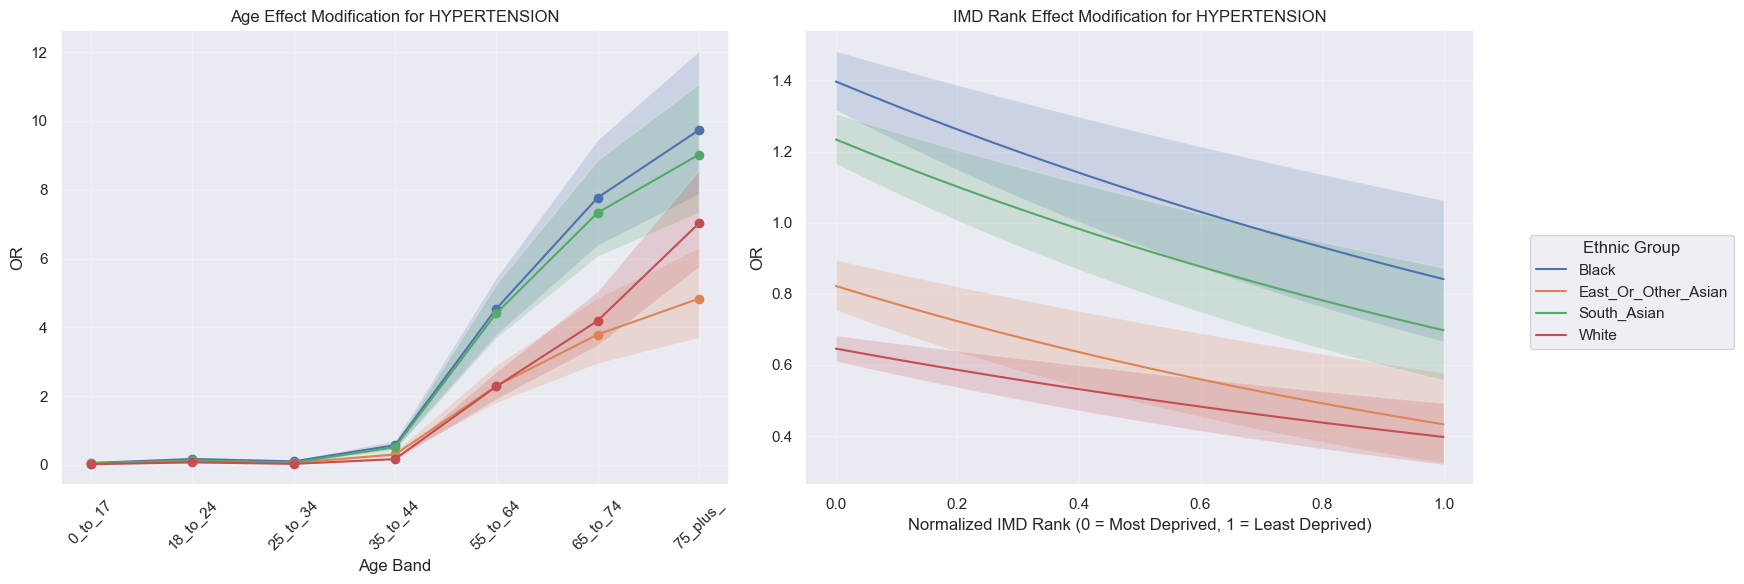

SHOWING: CORONARY_HEART_DISEASE


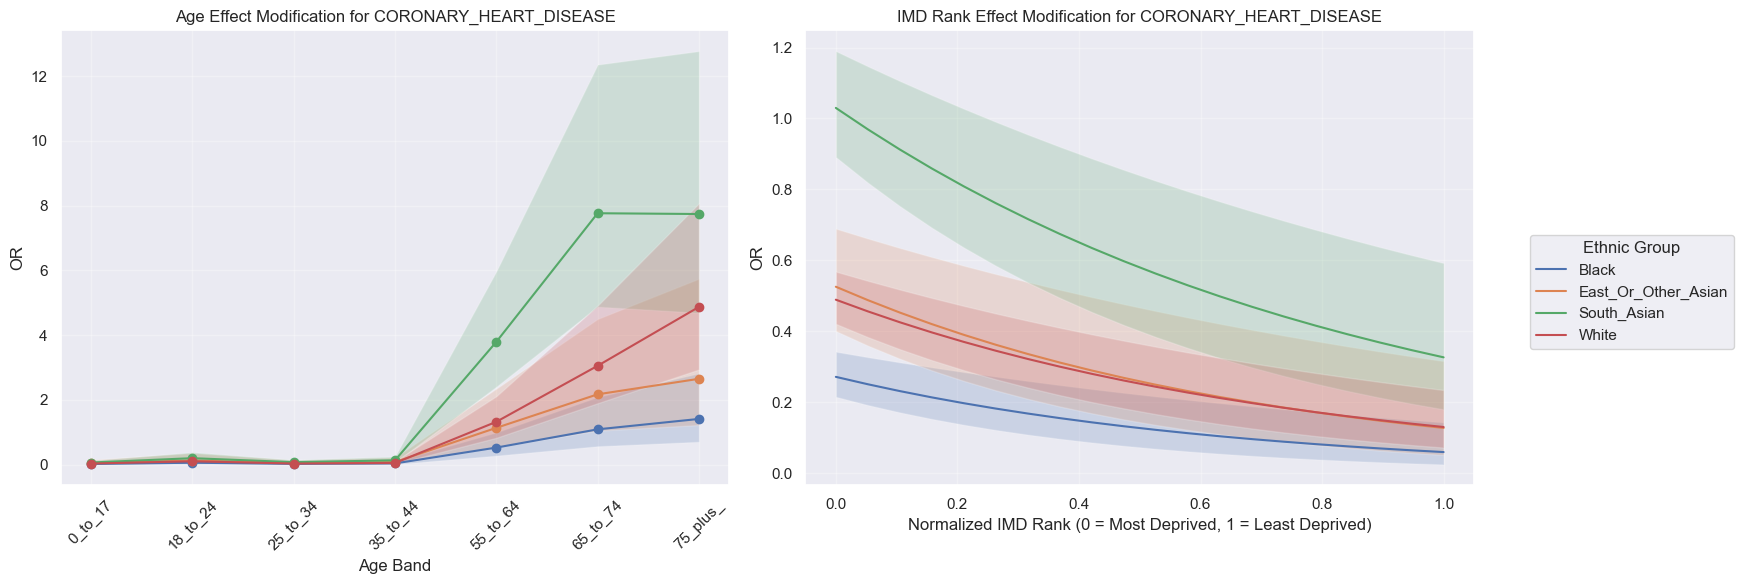

SHOWING: MYOCARDIAL_INFARCTION


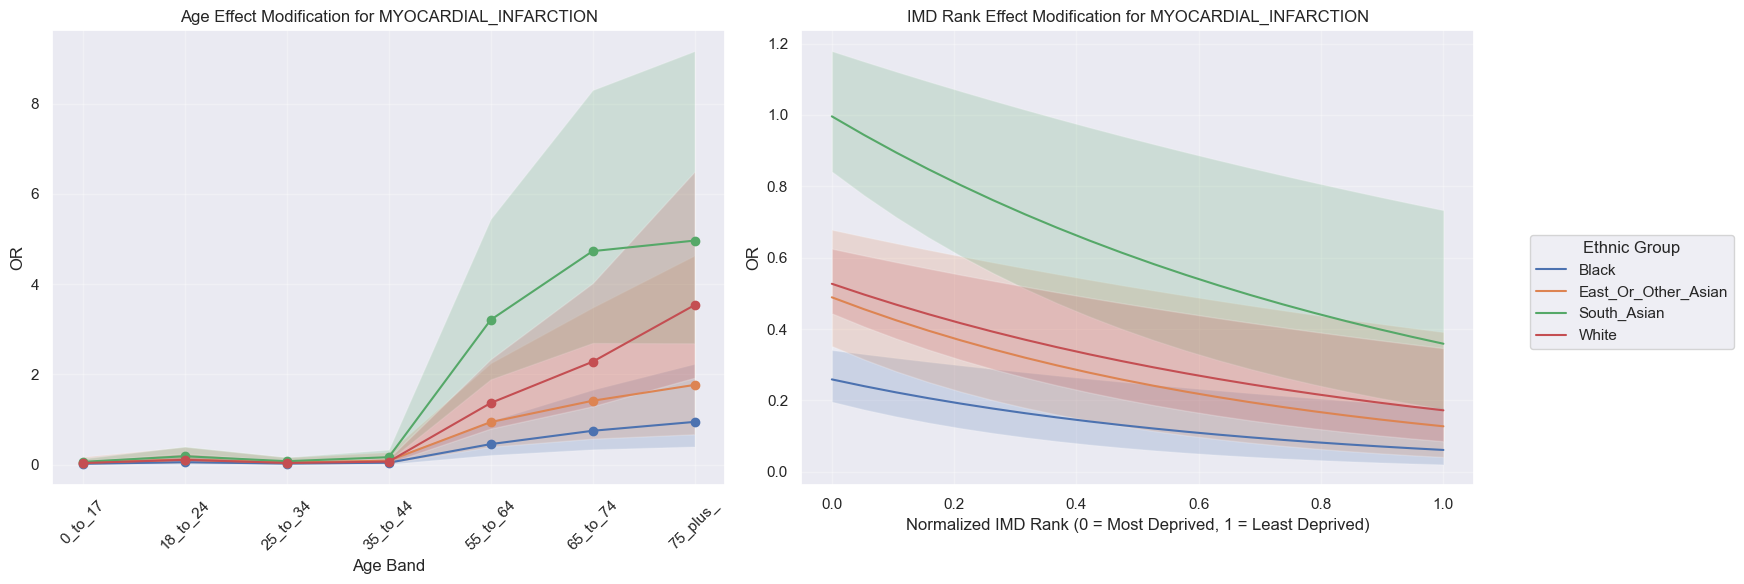

SHOWING: TIA


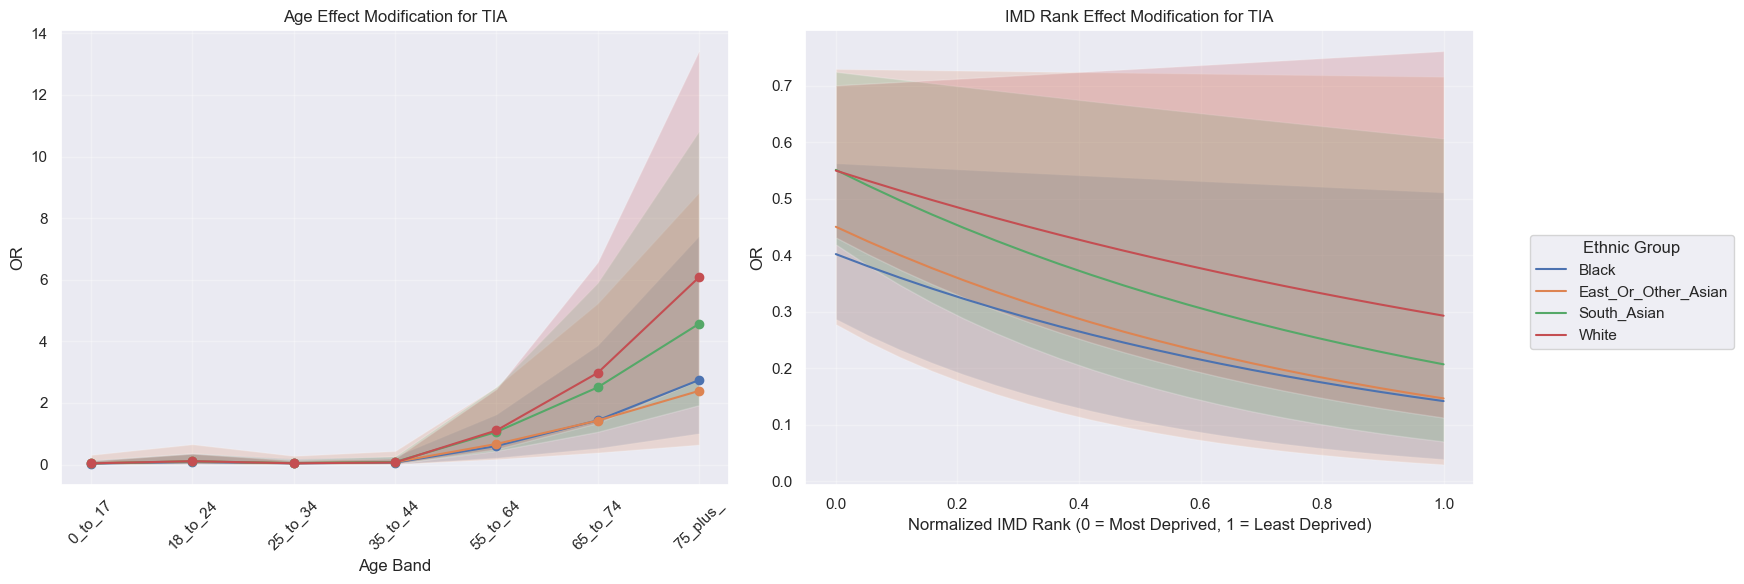

SHOWING: STROKE


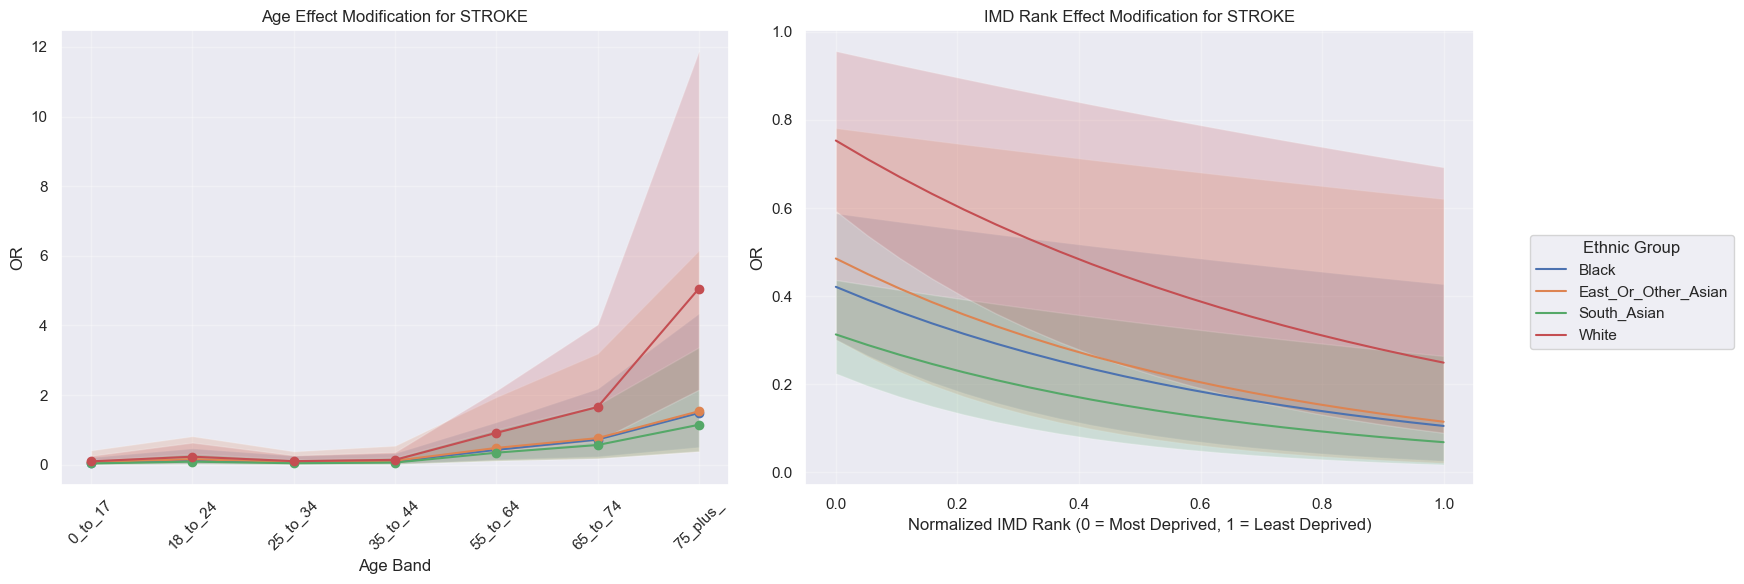

SHOWING: CKD_STAGE1


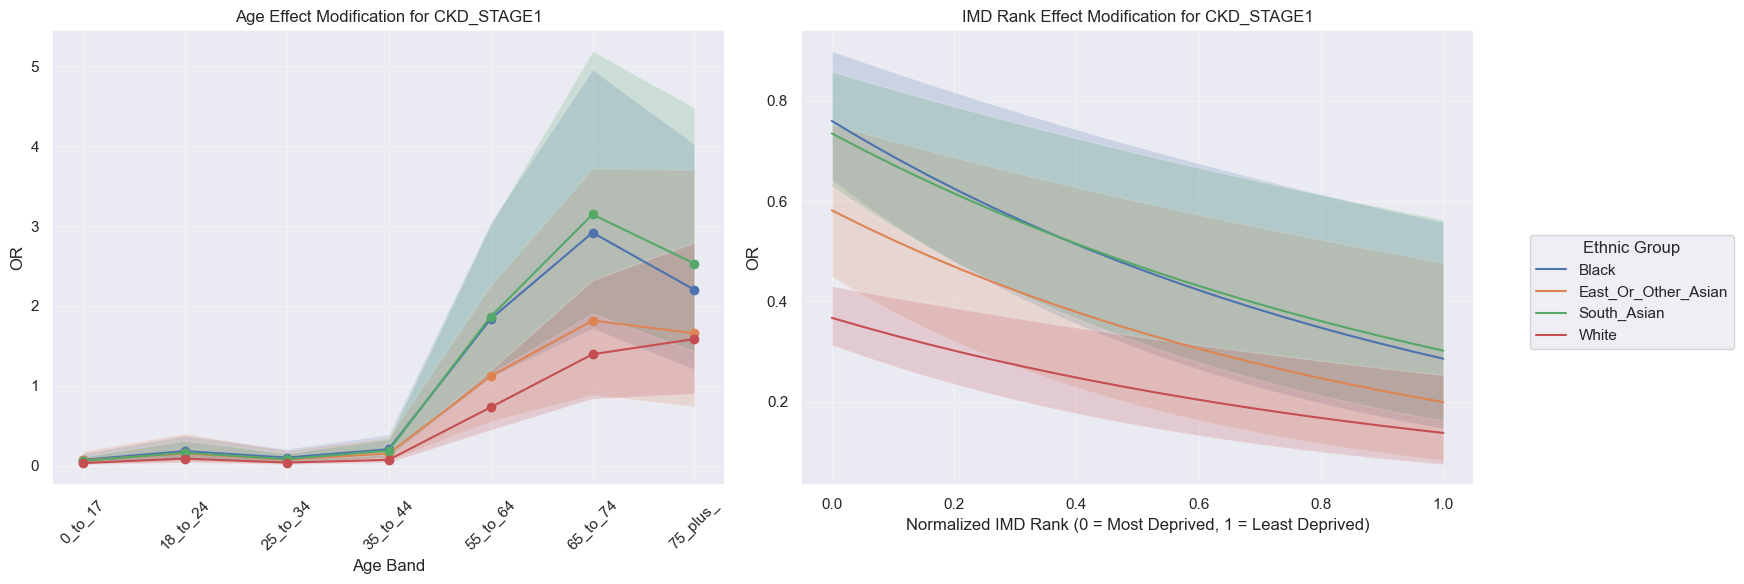

SHOWING: CKD_STAGE3


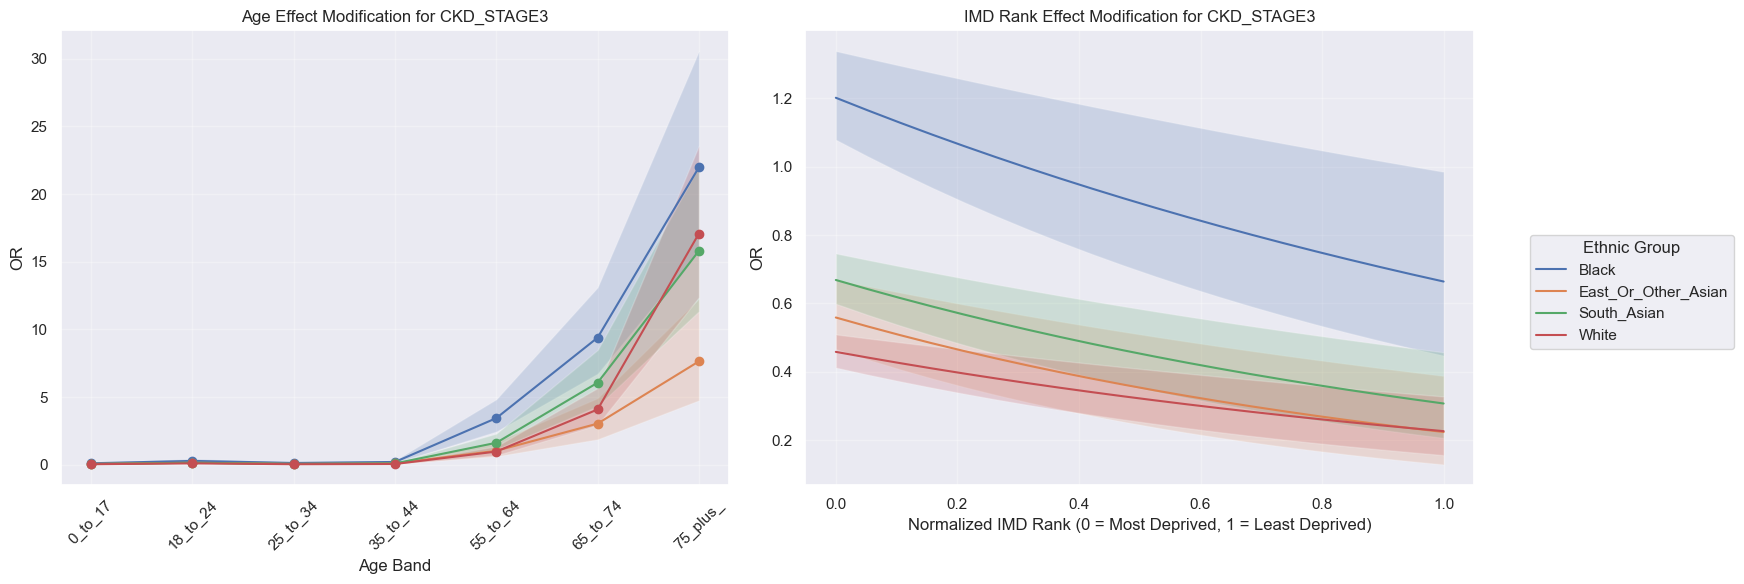

SHOWING: DEPRESSION


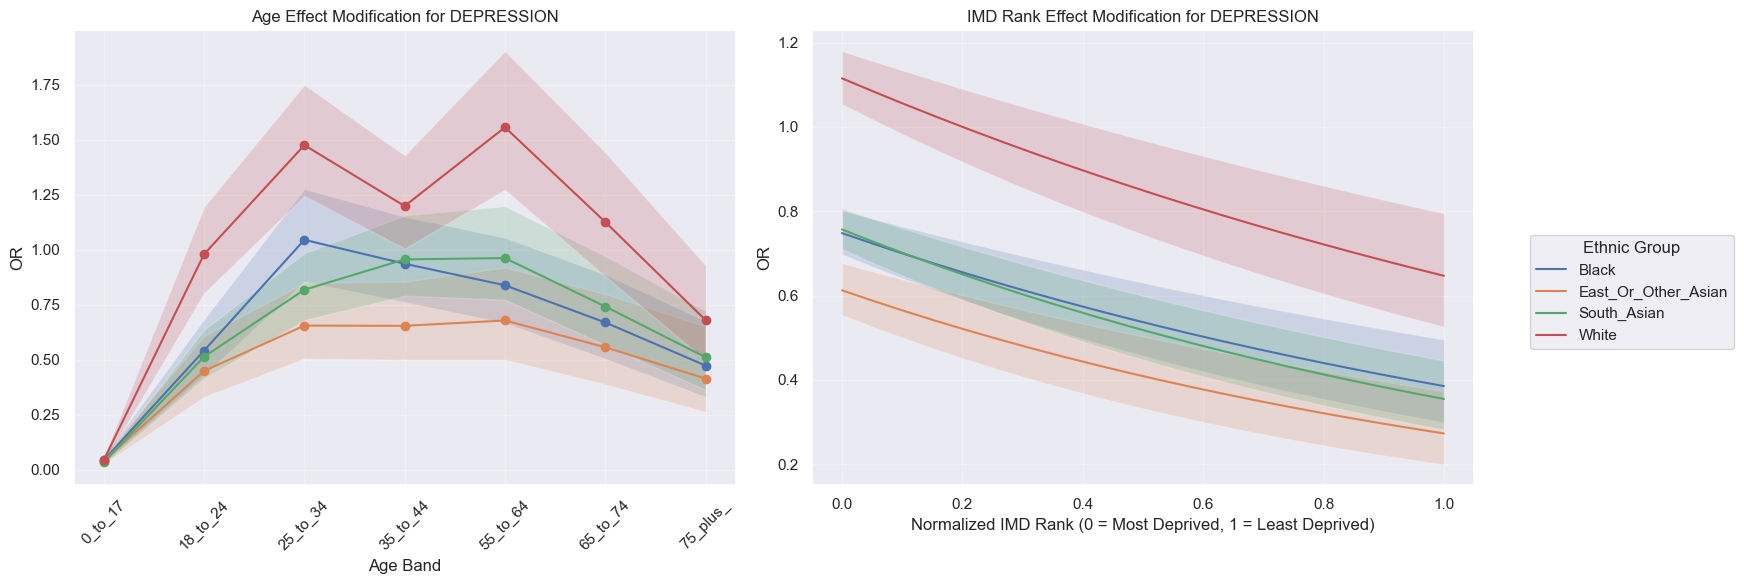

SHOWING: SEVERE_MENTAL_ILLNESS


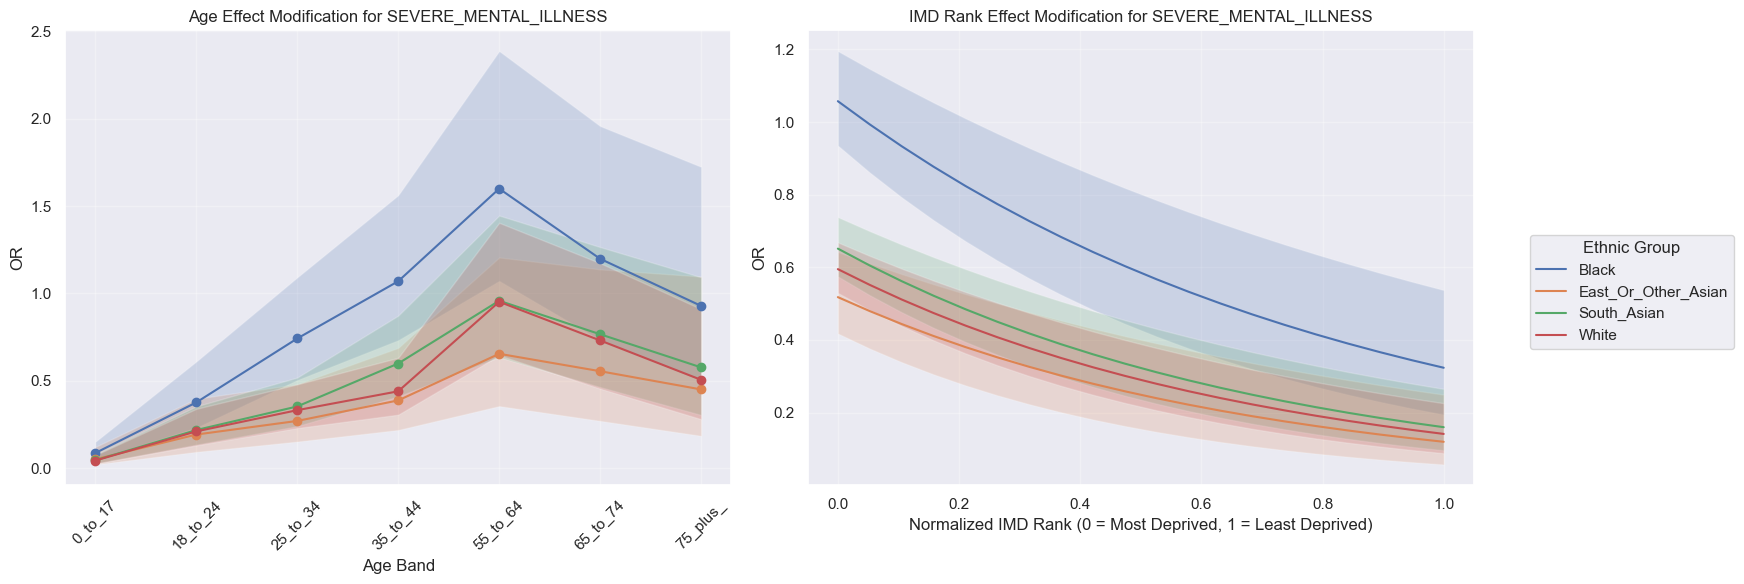

SHOWING: CANCER


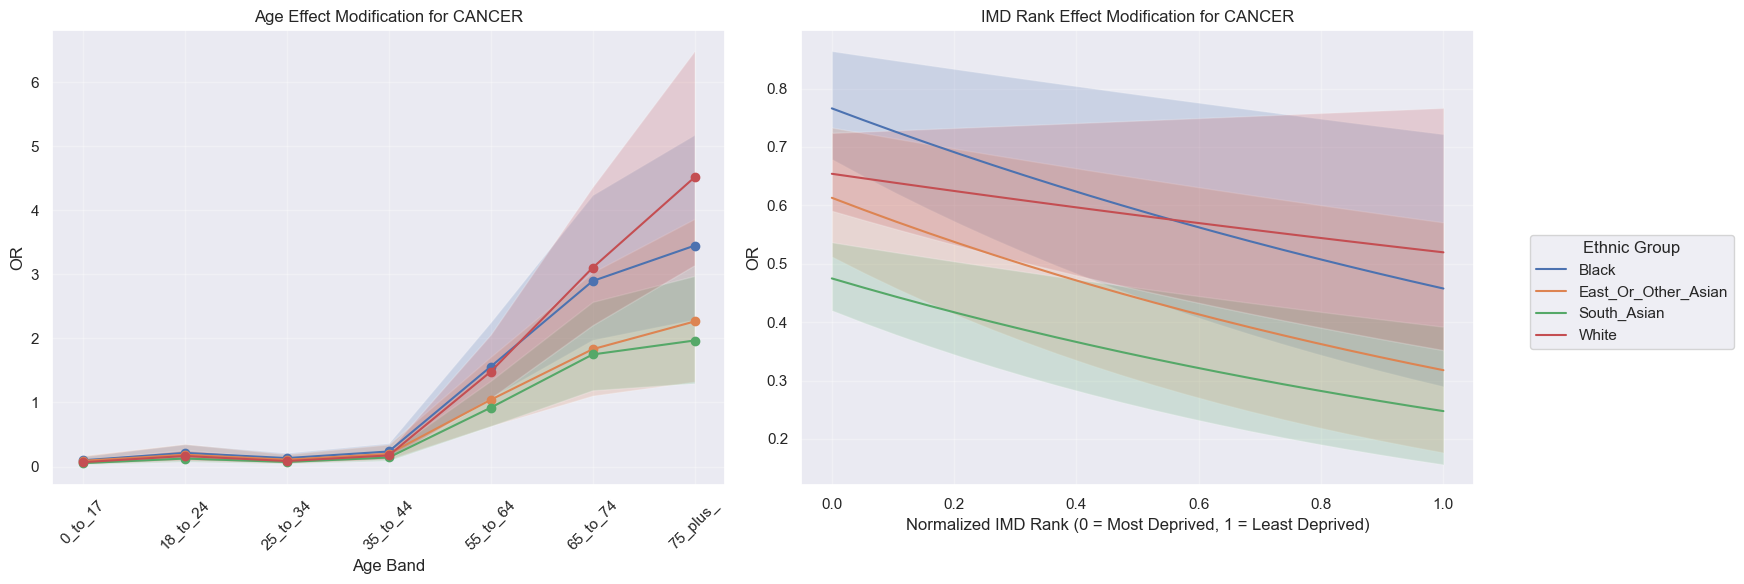

SHOWING: DEMENTIA


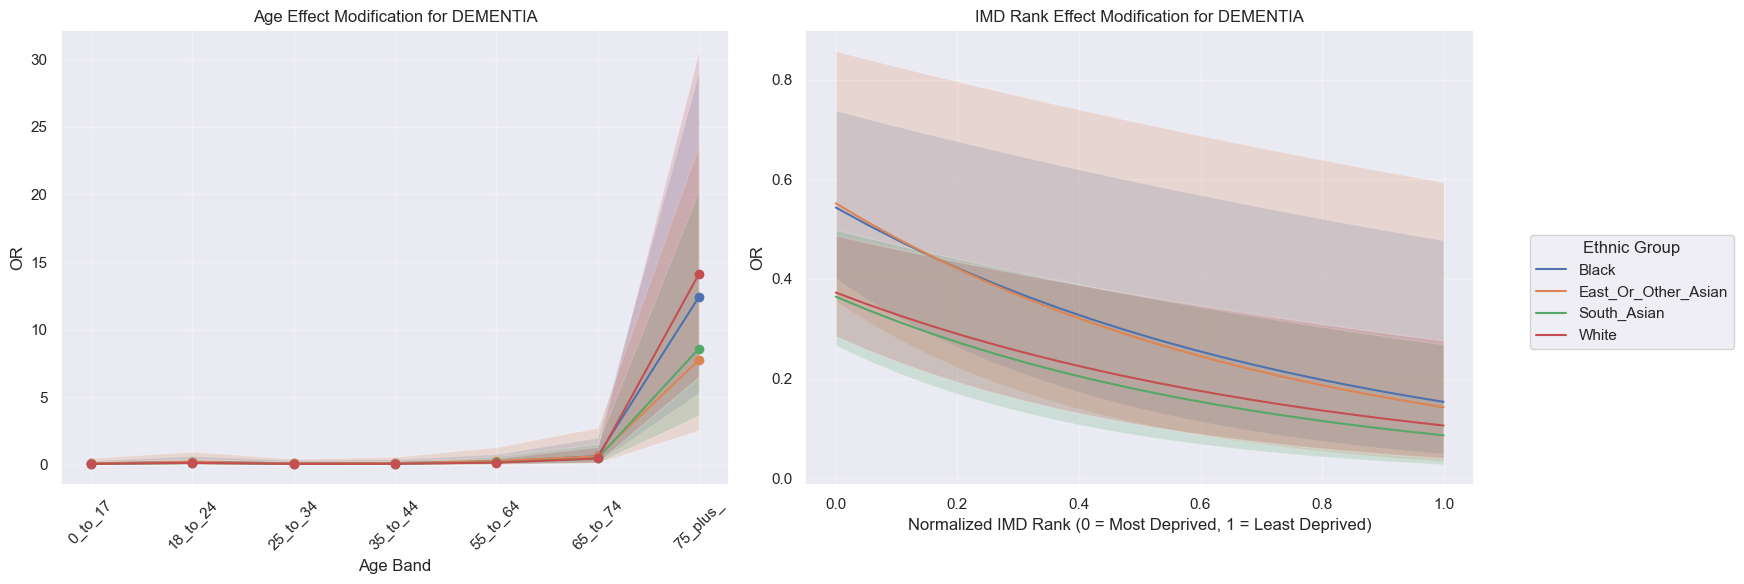

SHOWING: ATRIAL_FIBRILLATION


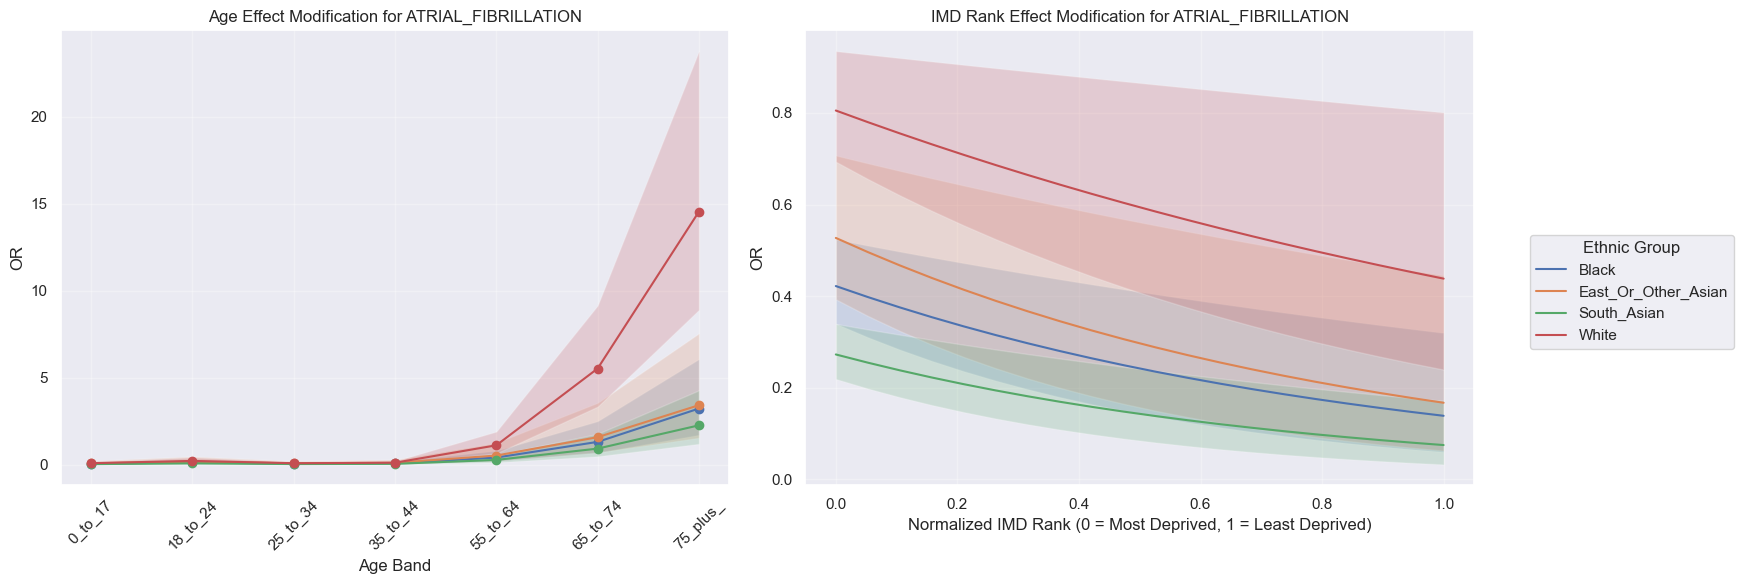

SHOWING: PALLIATIVE_CARE


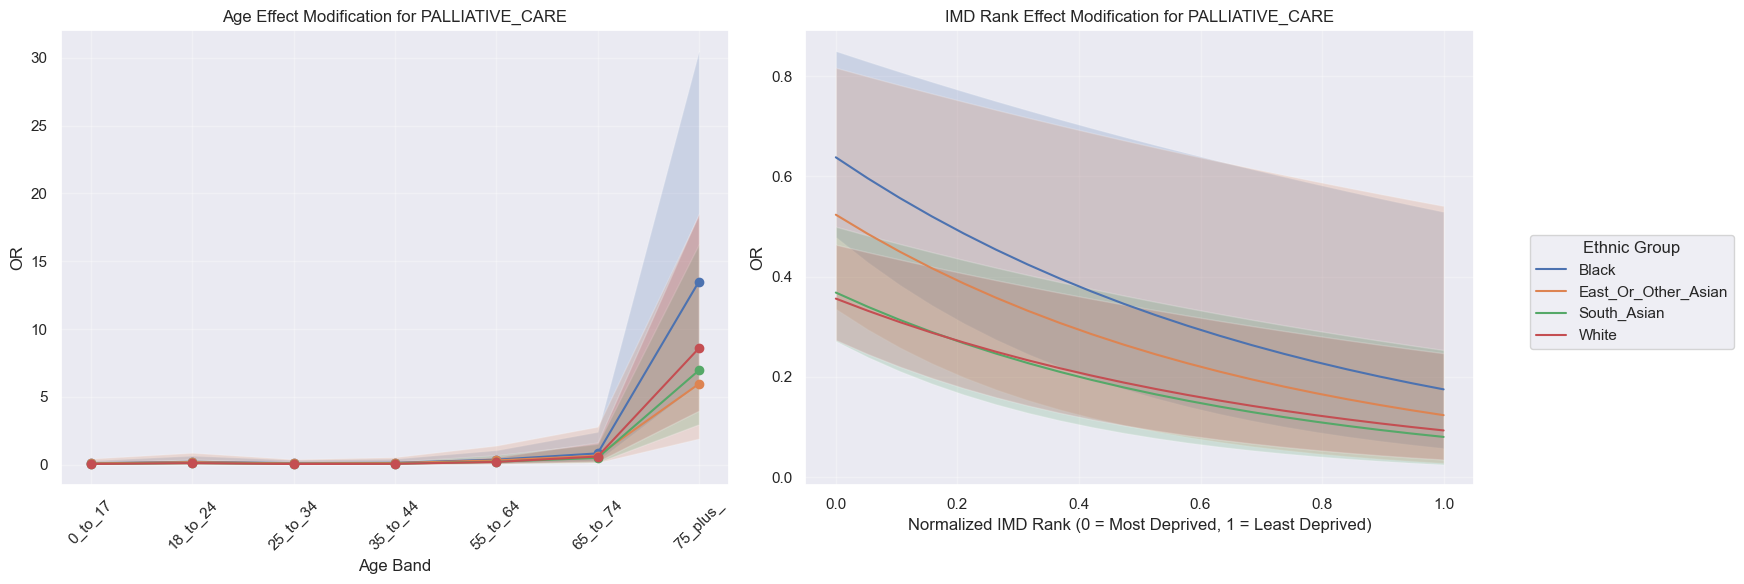

In [21]:
def main():
    """
    Creates effect modification analysis for all phenotypes and combines into single dataset
    Performs risk analysis and prediction for all phenotypes and combines into single dataset
    Uploads both to Snowflake
    """
    load_dotenv()

    try:
        effect_dfs = []
        risk_dfs = []

        # Process each phenotype
        for phenotype in tqdm(PHENOTYPES_OF_INTEREST.keys(), desc="Processing phenotypes"):
            print(f"Now modelling {phenotype}")

            # Get and process data
            df = get_modeling_data(snowsesh, phenotype)
            model_df, metadata = prepare_modeling_data(df, phenotype)
            model_results = fit_logistic_models(model_df, metadata, phenotype)

            # Generate and store effects with phenotype label
            effect_df = create_effect_modification_df(model_results, metadata)
            effect_df['phenotype'] = phenotype
            effect_dfs.append(effect_df)
            print(f"{phenotype} effects appended")

            # Generate and store predicted risks with phenotype label
            risk_df = calculate_individual_risks(df, model_results, metadata)
            geo_analysis = analyse_geographic_risk(risk_df, phenotype)
            geo_analysis['phenotype'] = phenotype
            key_cols = [
                'PATIENT_LSOA_2011',
                'phenotype',
                'population',
                'actual_cases',
                'expected_cases',
                'case_difference',
                'standardized_difference',
                'significant_under_diagnosis'
            ]
            risk_dfs.append(geo_analysis[key_cols])

        # Combine all effects and save
        phenotype_effects = pd.concat(effect_dfs, ignore_index=True)
        phenotype_effects.to_csv('phenotype_effects.csv', index=False)
        print(f"Saved combined effects for {len(PHENOTYPES_OF_INTEREST)} phenotypes")

        # Combine all calculated risks and save
        combined_risk_analysis = pd.concat(risk_dfs, ignore_index=True)
        combined_risk_analysis.to_csv('risk_analysis.csv', index=False)
        print(f"Saved combined risk analysis for {len(PHENOTYPES_OF_INTEREST)} phenotypes")

        # Create effect visualisations
        for phenotype in PHENOTYPES_OF_INTEREST.keys():
            try:
                phenotype_data = phenotype_effects[phenotype_effects['phenotype'] == phenotype]
                fig = plot_effect_modifications(phenotype_data, phenotype)
                print(f"SHOWING: {phenotype}")
                plt.show()
            except:
                pass

    except Exception as e:
        print(f"Error in main process: {e}")
        raise e

if __name__ == "__main__":
    main()

## Save to Snowflake

In [22]:
snowsesh.load_csv_as_table(
    csv_path='phenotype_effects.csv',
    table_name='PHENOTYPE_ADJUSTED_EFFECTS',
    mode="overwrite"
)

snowsesh.load_csv_as_table(
    csv_path='risk_analysis.csv',
    table_name='PHENOTYPE_GEOSPATIAL_RISK',
    mode="overwrite"
)

Data loaded successfully
Data loaded successfully


'PHENOTYPE_GEOSPATIAL_RISK'